# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 1.0 MB 9.2 MB/s 
     |████████████████████████████████| 6.3 MB 8.4 MB/s 
     |████████████████████████████████| 16.7 MB 2.7 MB/s 
     |████████████████████████████████| 1.0 MB 25.6 MB/s 
     |████████████████████████████████| 2.1 MB 15.6 MB/s 


## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase3_all_to_20220311.csv')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
OCT_poly1 = Polygon([(22.1, 12.8), (22.1, 8.8), (29.8, 8.8), (29.8, 12.8)])

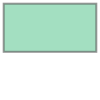

In [ ]:
OCT_poly1

In [ ]:
OCT_poly2 = Polygon([(24.3, 6.3), (24.3, 3.7), (26.3, 3.7), (26.3, 6.3)])

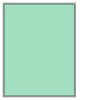

In [ ]:
OCT_poly2

## MultiPolygon Creation

In this example there are two separate sections for the machines. So multiple polygons must be created and subsequently combined to create a MultiPolygon.

In [ ]:
OCT_multipoly = MultiPolygon([OCT_poly1, OCT_poly2])

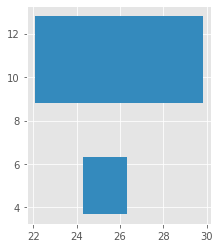

In [ ]:
 p = gpd.GeoSeries(OCT_multipoly)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient', 'Location', 'from', 'to', 'xlocation', 'ylocation']

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframeusing the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

In [ ]:
OCT_multipoly_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(OCT_multipoly))

In [ ]:
OCT_multipoly_gdf

,geometry
0,"MULTIPOLYGON (((22.10000 12.80000, 22.10000 8...."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
OCT_join = gpd.sjoin(gdf, OCT_multipoly_gdf, how = 'inner')
OCT_join

,Patient,Location,from,to,xlocation,ylocation,geometry,index_right
102,G2341,"24.435,11.836",07/03/2022 11:26,07/03/2022 11:33,24.435,11.836,POINT (24.43500 11.83600),0
103,G2341,"24.805,10.736",07/03/2022 11:33,07/03/2022 11:33,24.805,10.736,POINT (24.80500 10.73600),0
104,G2341,"23.709,9.794",07/03/2022 11:33,07/03/2022 11:33,23.709,9.794,POINT (23.70900 9.79400),0
105,G2341,"24.123,10.707",07/03/2022 11:33,07/03/2022 11:33,24.123,10.707,POINT (24.12300 10.70700),0
106,G2341,"23.709,9.794",07/03/2022 11:33,07/03/2022 11:34,23.709,9.794,POINT (23.70900 9.79400),0
...,...,...,...,...,...,...,...,...
16179,R1615,"28.96,9.789",11/03/2022 16:27,11/03/2022 16:36,28.96,9.789,POINT (28.96000 9.78900),0
16188,R1615,"29.66,9.789",11/03/2022 16:40,11/03/2022 16:40,29.66,9.789,POINT (29.66000 9.78900),0
16226,R2409,"27.042,11.835",09/03/2022 15:57,09/03/2022 15:57,27.042,11.835,POINT (27.04200 11.83500),0
16228,R2409,"27.042,11.835",09/03/2022 15:57,09/03/2022 15:58,27.042,11.835,POINT (27.04200 11.83500),0


## More data cleaning

## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
OCT_join['newfrom'] = lookup(OCT_join['from'], format='%d/%m/%Y %H:%M')
OCT_join['newto'] = lookup(OCT_join['to'], format='%d/%m/%Y %H:%M')

In [ ]:
dfgrouped = OCT_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G2341,2022-03-07 11:26:00,2022-03-07 12:00:00
1,G2342,2022-03-07 11:04:00,2022-03-07 11:18:00
2,G2343,2022-03-07 10:43:00,2022-03-07 10:54:00
3,G2344,2022-03-07 11:26:00,2022-03-07 11:31:00
4,G2345,2022-03-07 11:01:00,2022-03-07 11:07:00
5,G2346,2022-03-07 10:55:00,2022-03-07 11:58:00
6,G2347,2022-03-07 11:15:00,2022-03-07 12:21:00
7,G2348,2022-03-07 11:09:00,2022-03-07 11:15:00
8,G2349,2022-03-07 11:26:00,2022-03-07 11:36:00
9,G2350,2022-03-07 11:52:00,2022-03-07 12:03:00


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal', 'not_equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 01:31:00')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G2341,2022-03-07 11:26:00,2022-03-07 12:00:00,0 days 00:34:00,7,7,equal
1,G2342,2022-03-07 11:04:00,2022-03-07 11:18:00,0 days 00:14:00,7,7,equal
2,G2343,2022-03-07 10:43:00,2022-03-07 10:54:00,0 days 00:11:00,7,7,equal
3,G2344,2022-03-07 11:26:00,2022-03-07 11:31:00,0 days 00:05:00,7,7,equal
4,G2345,2022-03-07 11:01:00,2022-03-07 11:07:00,0 days 00:06:00,7,7,equal
5,G2346,2022-03-07 10:55:00,2022-03-07 11:58:00,0 days 01:03:00,7,7,equal
6,G2347,2022-03-07 11:15:00,2022-03-07 12:21:00,0 days 01:06:00,7,7,equal
7,G2348,2022-03-07 11:09:00,2022-03-07 11:15:00,0 days 00:06:00,7,7,equal
8,G2349,2022-03-07 11:26:00,2022-03-07 11:36:00,0 days 00:10:00,7,7,equal
9,G2350,2022-03-07 11:52:00,2022-03-07 12:03:00,0 days 00:11:00,7,7,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 01:31:00')

In [ ]:
dfgrouped['visit_length'].describe()

count                          179
mean     0 days 00:16:10.726256983
std      0 days 00:12:21.453952696
min                0 days 00:03:00
25%                0 days 00:08:00
50%                0 days 00:13:00
75%                0 days 00:19:00
max                0 days 01:31:00
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G2341,2022-03-07 11:26:00,2022-03-07 12:00:00,0 days 00:34:00,7,7,equal,Monday
1,G2342,2022-03-07 11:04:00,2022-03-07 11:18:00,0 days 00:14:00,7,7,equal,Monday
2,G2343,2022-03-07 10:43:00,2022-03-07 10:54:00,0 days 00:11:00,7,7,equal,Monday
3,G2344,2022-03-07 11:26:00,2022-03-07 11:31:00,0 days 00:05:00,7,7,equal,Monday
4,G2345,2022-03-07 11:01:00,2022-03-07 11:07:00,0 days 00:06:00,7,7,equal,Monday
5,G2346,2022-03-07 10:55:00,2022-03-07 11:58:00,0 days 01:03:00,7,7,equal,Monday
6,G2347,2022-03-07 11:15:00,2022-03-07 12:21:00,0 days 01:06:00,7,7,equal,Monday
7,G2348,2022-03-07 11:09:00,2022-03-07 11:15:00,0 days 00:06:00,7,7,equal,Monday
8,G2349,2022-03-07 11:26:00,2022-03-07 11:36:00,0 days 00:10:00,7,7,equal,Monday
9,G2350,2022-03-07 11:52:00,2022-03-07 12:03:00,0 days 00:11:00,7,7,equal,Monday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G2341,2022-03-07 11:26:00,2022-03-07 12:00:00,0 days 00:34:00,7,7,equal,Monday
1,G2342,2022-03-07 11:04:00,2022-03-07 11:18:00,0 days 00:14:00,7,7,equal,Monday
2,G2343,2022-03-07 10:43:00,2022-03-07 10:54:00,0 days 00:11:00,7,7,equal,Monday
3,G2344,2022-03-07 11:26:00,2022-03-07 11:31:00,0 days 00:05:00,7,7,equal,Monday
4,G2345,2022-03-07 11:01:00,2022-03-07 11:07:00,0 days 00:06:00,7,7,equal,Monday
5,G2346,2022-03-07 10:55:00,2022-03-07 11:58:00,0 days 01:03:00,7,7,equal,Monday
6,G2347,2022-03-07 11:15:00,2022-03-07 12:21:00,0 days 01:06:00,7,7,equal,Monday
7,G2348,2022-03-07 11:09:00,2022-03-07 11:15:00,0 days 00:06:00,7,7,equal,Monday
8,G2349,2022-03-07 11:26:00,2022-03-07 11:36:00,0 days 00:10:00,7,7,equal,Monday
9,G2350,2022-03-07 11:52:00,2022-03-07 12:03:00,0 days 00:11:00,7,7,equal,Monday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon   0 days 00:16:13.846153846
morning     0 days 00:16:08.316831683
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:17:32.195121951
Tuesday,0 days 00:18:13.846153846
Wednesday,0 days 00:15:43.125000
Thursday,0 days 00:14:03.243243243
Friday,0 days 00:14:46
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
41
Tuesday
39
Wednesday
32
Thursday
37
Friday
30
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G2341,2022-03-07 11:26:00,2022-03-07 12:00:00,0 days 00:34:00,7,7,equal,Monday,morning,11
1,G2342,2022-03-07 11:04:00,2022-03-07 11:18:00,0 days 00:14:00,7,7,equal,Monday,morning,11
2,G2343,2022-03-07 10:43:00,2022-03-07 10:54:00,0 days 00:11:00,7,7,equal,Monday,morning,10
3,G2344,2022-03-07 11:26:00,2022-03-07 11:31:00,0 days 00:05:00,7,7,equal,Monday,morning,11
4,G2345,2022-03-07 11:01:00,2022-03-07 11:07:00,0 days 00:06:00,7,7,equal,Monday,morning,11
5,G2346,2022-03-07 10:55:00,2022-03-07 11:58:00,0 days 01:03:00,7,7,equal,Monday,morning,10
6,G2347,2022-03-07 11:15:00,2022-03-07 12:21:00,0 days 01:06:00,7,7,equal,Monday,morning,11
7,G2348,2022-03-07 11:09:00,2022-03-07 11:15:00,0 days 00:06:00,7,7,equal,Monday,morning,11
8,G2349,2022-03-07 11:26:00,2022-03-07 11:36:00,0 days 00:10:00,7,7,equal,Monday,morning,11
9,G2350,2022-03-07 11:52:00,2022-03-07 12:03:00,0 days 00:11:00,7,7,equal,Monday,morning,11


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
10   0 days 00:18:46.363636363
11   0 days 00:15:57.272727272
12   0 days 00:12:51.724137931
13             0 days 00:23:40
14   0 days 00:16:18.333333333
15   0 days 00:16:34.054054054
16             0 days 00:13:12
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
0
Ten
22
Eleven
44
Twelve
29
One
6
Two
36
Three
37
Four
5


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:17:05.242718446
R   0 days 00:14:56.842105263
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
103
Medical Retinal
76


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 11:26:00,2022-03-07 12:00:00,0 days 00:34:00,7,7,equal,Monday,morning,11,G,34.0000
1,G2342,2022-03-07 11:04:00,2022-03-07 11:18:00,0 days 00:14:00,7,7,equal,Monday,morning,11,G,14.0000
2,G2343,2022-03-07 10:43:00,2022-03-07 10:54:00,0 days 00:11:00,7,7,equal,Monday,morning,10,G,11.0000
3,G2344,2022-03-07 11:26:00,2022-03-07 11:31:00,0 days 00:05:00,7,7,equal,Monday,morning,11,G,5.0000
4,G2345,2022-03-07 11:01:00,2022-03-07 11:07:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
5,G2346,2022-03-07 10:55:00,2022-03-07 11:58:00,0 days 01:03:00,7,7,equal,Monday,morning,10,G,63.0000
6,G2347,2022-03-07 11:15:00,2022-03-07 12:21:00,0 days 01:06:00,7,7,equal,Monday,morning,11,G,66.0000
7,G2348,2022-03-07 11:09:00,2022-03-07 11:15:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
8,G2349,2022-03-07 11:26:00,2022-03-07 11:36:00,0 days 00:10:00,7,7,equal,Monday,morning,11,G,10.0000
9,G2350,2022-03-07 11:52:00,2022-03-07 12:03:00,0 days 00:11:00,7,7,equal,Monday,morning,11,G,11.0000


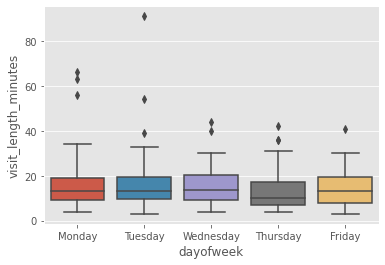

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

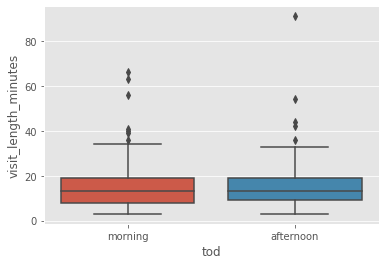

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

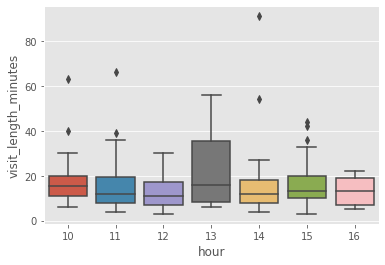

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

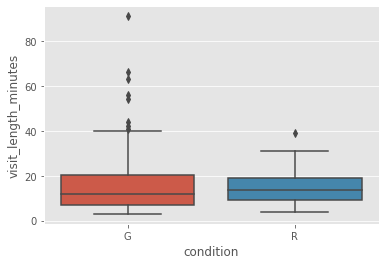

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 57
newfrom                 57
newto                   57
visit_length            57
start_day               57
end_day                 57
sameday                 57
dayofweek               57
tod                     57
hour                    57
condition               57
visit_length_minutes    57
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 11:26:00,2022-03-07 12:00:00,0 days 00:34:00,7,7,equal,Monday,morning,11,G,34.0000
1,G2342,2022-03-07 11:04:00,2022-03-07 11:18:00,0 days 00:14:00,7,7,equal,Monday,morning,11,G,14.0000
2,G2343,2022-03-07 10:43:00,2022-03-07 10:54:00,0 days 00:11:00,7,7,equal,Monday,morning,10,G,11.0000
3,G2344,2022-03-07 11:26:00,2022-03-07 11:31:00,0 days 00:05:00,7,7,equal,Monday,morning,11,G,5.0000
4,G2345,2022-03-07 11:01:00,2022-03-07 11:07:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
7,G2348,2022-03-07 11:09:00,2022-03-07 11:15:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
8,G2349,2022-03-07 11:26:00,2022-03-07 11:36:00,0 days 00:10:00,7,7,equal,Monday,morning,11,G,10.0000
9,G2350,2022-03-07 11:52:00,2022-03-07 12:03:00,0 days 00:11:00,7,7,equal,Monday,morning,11,G,11.0000
10,G2351,2022-03-07 12:09:00,2022-03-07 12:19:00,0 days 00:10:00,7,7,equal,Monday,morning,12,G,10.0000
11,G2352,2022-03-07 12:37:00,2022-03-07 12:44:00,0 days 00:07:00,7,7,equal,Monday,morning,12,G,7.0000


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

14.74712643678161
14.74712643678161


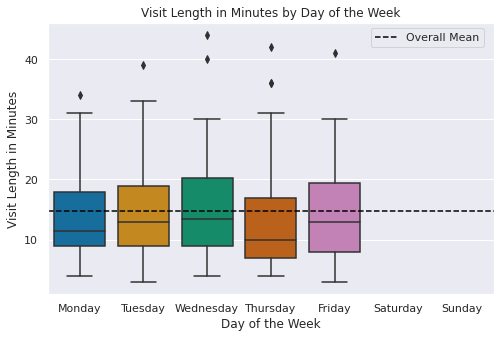

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

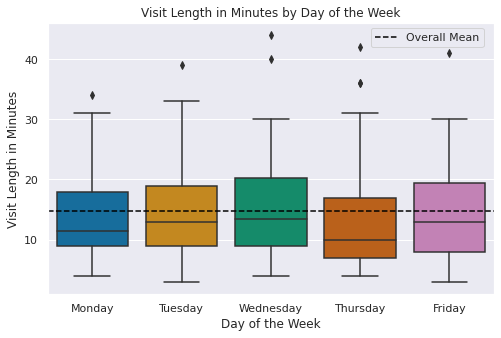

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

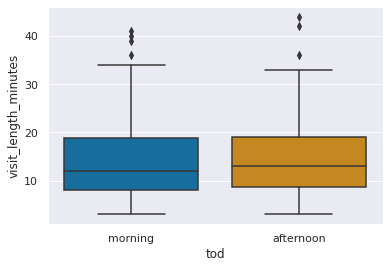

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

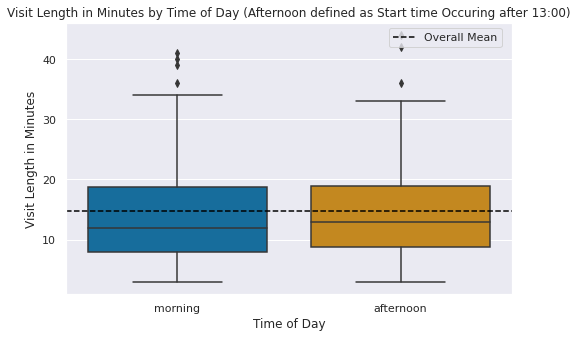

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

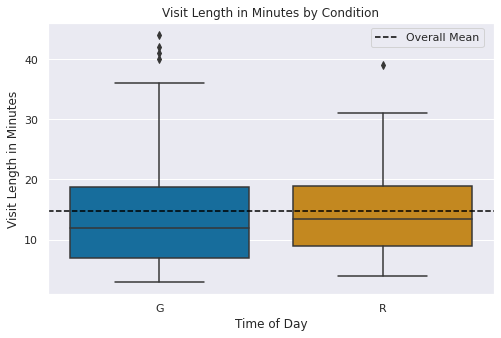

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

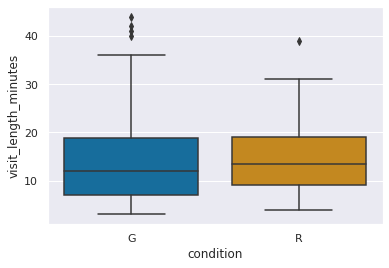

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

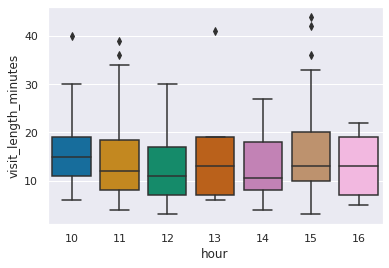

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

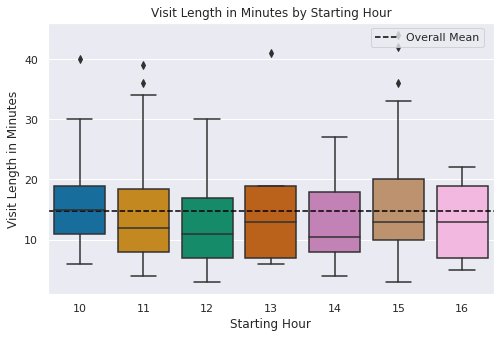

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                   174.0000
mean                                     14.7471
std                                       8.8458
min                                       3.0000
25%                                       8.0000
50%                                      13.0000
75%                                      19.0000
max                                      44.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                   179.0000
mean                                     16.1788
std                                      12.3576
min                                       3.0000
25%                                       8.0000
50%                                      13.0000
75%                                      19.0000
max                                      91.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

13.0

In [ ]:
df_outliers['visit_length'].describe()

count                          174
mean     0 days 00:14:44.827586206
std      0 days 00:08:50.746800869
min                0 days 00:03:00
25%                0 days 00:08:00
50%                0 days 00:13:00
75%                0 days 00:19:00
max                0 days 00:44:00
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                          179
mean     0 days 00:16:10.726256983
std      0 days 00:12:21.453952696
min                0 days 00:03:00
25%                0 days 00:08:00
50%                0 days 00:13:00
75%                0 days 00:19:00
max                0 days 01:31:00
Name: visit_length, dtype: object

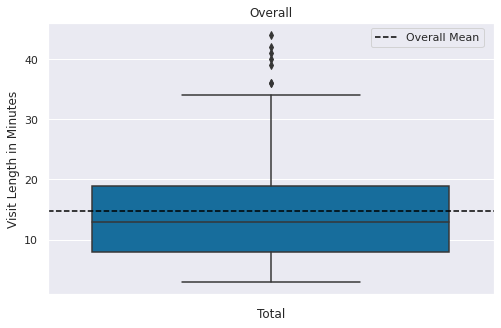

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
21
Eleven
43
Twelve
29
One
5
Two
34
Three
37
Four
5


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
38
Tuesday Outlier
37
Wednesday Outlier
32
Thursday Outlier
37
Friday Outlier
30
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                       14.0526
Tuesday                                      15.2973
Wednesday                                    15.7188
Thursday                                     14.0541
Friday                                       14.7667
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
98
R
76


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                    14.5918
R                                    14.9474
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
98
afternoon
76


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                    14.7500
morning                                      14.7449
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
21
Eleven
43
Twelve
29
One
5
Two
34
Three
37
Four
5


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
10                                    16.6667
11                                    14.7907
12                                    12.8621
13                                    17.2000
14                                    13.0000
15                                    16.5676
16                                    13.2000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 57
newfrom                 57
newto                   57
visit_length            57
start_day               57
end_day                 57
sameday                 57
dayofweek               57
tod                     57
hour                    57
condition               57
visit_length_minutes    57
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 0
newfrom                 0
newto                   0
visit_length            0
start_day               0
end_day                 0
sameday                 0
dayofweek               0
tod                     0
hour                    0
condition               0
visit_length_minutes    0
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 174
newfrom                 174
newto                   174
visit_length            174
start_day               174
end_day                 174
sameday                 174
dayofweek               174
tod                     174
hour                    174
condition               174
visit_length_minutes    174
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
45,G2388,2022-03-08 15:54:00,2022-03-08 15:57:00,0 days 00:03:00,8,8,equal,Tuesday,afternoon,15,G,3.0000
92,G2441,2022-03-11 12:47:00,2022-03-11 12:50:00,0 days 00:03:00,11,11,equal,Friday,morning,12,G,3.0000
31,G2374,2022-03-08 12:38:00,2022-03-08 12:42:00,0 days 00:04:00,8,8,equal,Tuesday,morning,12,G,4.0000
53,G2396,2022-03-09 11:42:00,2022-03-09 11:46:00,0 days 00:04:00,9,9,equal,Wednesday,morning,11,G,4.0000
82,G2428,2022-03-10 15:56:00,2022-03-10 16:00:00,0 days 00:04:00,10,10,equal,Thursday,afternoon,15,G,4.0000


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
45,G2388,2022-03-08 15:54:00,2022-03-08 15:57:00,0 days 00:03:00,8,8,equal,Tuesday,afternoon,15,G,3.0000
92,G2441,2022-03-11 12:47:00,2022-03-11 12:50:00,0 days 00:03:00,11,11,equal,Friday,morning,12,G,3.0000
31,G2374,2022-03-08 12:38:00,2022-03-08 12:42:00,0 days 00:04:00,8,8,equal,Tuesday,morning,12,G,4.0000
53,G2396,2022-03-09 11:42:00,2022-03-09 11:46:00,0 days 00:04:00,9,9,equal,Wednesday,morning,11,G,4.0000
82,G2428,2022-03-10 15:56:00,2022-03-10 16:00:00,0 days 00:04:00,10,10,equal,Thursday,afternoon,15,G,4.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
64,G2408,2022-03-09 15:10:00,2022-03-09 15:54:00,0 days 00:44:00,9,9,equal,Wednesday,afternoon,15,G,44.0000
79,G2425,2022-03-10 15:02:00,2022-03-10 15:44:00,0 days 00:42:00,10,10,equal,Thursday,afternoon,15,G,42.0000
95,G2444,2022-03-11 13:46:00,2022-03-11 14:27:00,0 days 00:41:00,11,11,equal,Friday,morning,13,G,41.0000
49,G2392,2022-03-09 10:27:00,2022-03-09 11:07:00,0 days 00:40:00,9,9,equal,Wednesday,morning,10,G,40.0000
126,R1560,2022-03-08 11:43:00,2022-03-08 12:22:00,0 days 00:39:00,8,8,equal,Tuesday,morning,11,R,39.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
64,G2408,2022-03-09 15:10:00,2022-03-09 15:54:00,0 days 00:44:00,9,9,equal,Wednesday,afternoon,15,G,44.0000
79,G2425,2022-03-10 15:02:00,2022-03-10 15:44:00,0 days 00:42:00,10,10,equal,Thursday,afternoon,15,G,42.0000
95,G2444,2022-03-11 13:46:00,2022-03-11 14:27:00,0 days 00:41:00,11,11,equal,Friday,morning,13,G,41.0000
49,G2392,2022-03-09 10:27:00,2022-03-09 11:07:00,0 days 00:40:00,9,9,equal,Wednesday,morning,10,G,40.0000
126,R1560,2022-03-08 11:43:00,2022-03-08 12:22:00,0 days 00:39:00,8,8,equal,Tuesday,morning,11,R,39.0000


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
41,G2384,2022-03-08 14:50:00,2022-03-08 16:21:00,0 days 01:31:00,8,8,equal,Tuesday,afternoon,14,G,91.0000
6,G2347,2022-03-07 11:15:00,2022-03-07 12:21:00,0 days 01:06:00,7,7,equal,Monday,morning,11,G,66.0000
5,G2346,2022-03-07 10:55:00,2022-03-07 11:58:00,0 days 01:03:00,7,7,equal,Monday,morning,10,G,63.0000
14,G2355,2022-03-07 13:37:00,2022-03-07 14:33:00,0 days 00:56:00,7,7,equal,Monday,morning,13,G,56.0000
38,G2381,2022-03-08 14:36:00,2022-03-08 15:30:00,0 days 00:54:00,8,8,equal,Tuesday,afternoon,14,G,54.0000
64,G2408,2022-03-09 15:10:00,2022-03-09 15:54:00,0 days 00:44:00,9,9,equal,Wednesday,afternoon,15,G,44.0000
79,G2425,2022-03-10 15:02:00,2022-03-10 15:44:00,0 days 00:42:00,10,10,equal,Thursday,afternoon,15,G,42.0000
95,G2444,2022-03-11 13:46:00,2022-03-11 14:27:00,0 days 00:41:00,11,11,equal,Friday,morning,13,G,41.0000
49,G2392,2022-03-09 10:27:00,2022-03-09 11:07:00,0 days 00:40:00,9,9,equal,Wednesday,morning,10,G,40.0000
126,R1560,2022-03-08 11:43:00,2022-03-08 12:22:00,0 days 00:39:00,8,8,equal,Tuesday,morning,11,R,39.0000


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
64,G2408,2022-03-09 15:10:00,2022-03-09 15:54:00,0 days 00:44:00,9,9,equal,Wednesday,afternoon,15,G,44.0000
79,G2425,2022-03-10 15:02:00,2022-03-10 15:44:00,0 days 00:42:00,10,10,equal,Thursday,afternoon,15,G,42.0000
95,G2444,2022-03-11 13:46:00,2022-03-11 14:27:00,0 days 00:41:00,11,11,equal,Friday,morning,13,G,41.0000
49,G2392,2022-03-09 10:27:00,2022-03-09 11:07:00,0 days 00:40:00,9,9,equal,Wednesday,morning,10,G,40.0000
126,R1560,2022-03-08 11:43:00,2022-03-08 12:22:00,0 days 00:39:00,8,8,equal,Tuesday,morning,11,R,39.0000
66,G2411,2022-03-10 11:15:00,2022-03-10 11:51:00,0 days 00:36:00,10,10,equal,Thursday,morning,11,G,36.0000
77,G2423,2022-03-10 15:01:00,2022-03-10 15:37:00,0 days 00:36:00,10,10,equal,Thursday,afternoon,15,G,36.0000
0,G2341,2022-03-07 11:26:00,2022-03-07 12:00:00,0 days 00:34:00,7,7,equal,Monday,morning,11,G,34.0000
43,G2386,2022-03-08 15:22:00,2022-03-08 15:55:00,0 days 00:33:00,8,8,equal,Tuesday,afternoon,15,G,33.0000
69,G2414,2022-03-10 11:38:00,2022-03-10 12:09:00,0 days 00:31:00,10,10,equal,Thursday,morning,11,G,31.0000


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 11:26:00,2022-03-07 12:00:00,0 days 00:34:00,7,7,equal,Monday,morning,11,G,34.0000
1,G2342,2022-03-07 11:04:00,2022-03-07 11:18:00,0 days 00:14:00,7,7,equal,Monday,morning,11,G,14.0000
2,G2343,2022-03-07 10:43:00,2022-03-07 10:54:00,0 days 00:11:00,7,7,equal,Monday,morning,10,G,11.0000
3,G2344,2022-03-07 11:26:00,2022-03-07 11:31:00,0 days 00:05:00,7,7,equal,Monday,morning,11,G,5.0000
4,G2345,2022-03-07 11:01:00,2022-03-07 11:07:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
7,G2348,2022-03-07 11:09:00,2022-03-07 11:15:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
8,G2349,2022-03-07 11:26:00,2022-03-07 11:36:00,0 days 00:10:00,7,7,equal,Monday,morning,11,G,10.0000
9,G2350,2022-03-07 11:52:00,2022-03-07 12:03:00,0 days 00:11:00,7,7,equal,Monday,morning,11,G,11.0000
10,G2351,2022-03-07 12:09:00,2022-03-07 12:19:00,0 days 00:10:00,7,7,equal,Monday,morning,12,G,10.0000
11,G2352,2022-03-07 12:37:00,2022-03-07 12:44:00,0 days 00:07:00,7,7,equal,Monday,morning,12,G,7.0000


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']


,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes


In [ ]:
df_outliers['clinic_location'] = 'OCT'
df_outliers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes,clinic_location
0,G2341,2022-03-07 11:26:00,2022-03-07 12:00:00,0 days 00:34:00,7,7,equal,Monday,morning,11,G,34.0000,OCT
1,G2342,2022-03-07 11:04:00,2022-03-07 11:18:00,0 days 00:14:00,7,7,equal,Monday,morning,11,G,14.0000,OCT
2,G2343,2022-03-07 10:43:00,2022-03-07 10:54:00,0 days 00:11:00,7,7,equal,Monday,morning,10,G,11.0000,OCT
3,G2344,2022-03-07 11:26:00,2022-03-07 11:31:00,0 days 00:05:00,7,7,equal,Monday,morning,11,G,5.0000,OCT
4,G2345,2022-03-07 11:01:00,2022-03-07 11:07:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000,OCT
7,G2348,2022-03-07 11:09:00,2022-03-07 11:15:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000,OCT
8,G2349,2022-03-07 11:26:00,2022-03-07 11:36:00,0 days 00:10:00,7,7,equal,Monday,morning,11,G,10.0000,OCT
9,G2350,2022-03-07 11:52:00,2022-03-07 12:03:00,0 days 00:11:00,7,7,equal,Monday,morning,11,G,11.0000,OCT
10,G2351,2022-03-07 12:09:00,2022-03-07 12:19:00,0 days 00:10:00,7,7,equal,Monday,morning,12,G,10.0000,OCT
11,G2352,2022-03-07 12:37:00,2022-03-07 12:44:00,0 days 00:07:00,7,7,equal,Monday,morning,12,G,7.0000,OCT


In [ ]:
OCTdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()

## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
OCTdf.to_csv('OCTdf_phase3.csv', index=False)